## 0. (Optional) Install dependencies

If you need to install packages, uncomment and run the cell below. Typical requirements: `numpy`, `pandas`, `matplotlib`, `seaborn`, `scikit-learn`, `joblib`, and optionally `torch` for a PyTorch model.

In [103]:
# %pip install numpy pandas matplotlib seaborn scikit-learn joblib
# Optional: torch torchvision
# %pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu

## 1. Imports

In [104]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, roc_curve, precision_recall_curve)
import joblib

# Optional PyTorch imports (only used in the optional section)
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader
    TORCH_AVAILABLE = True
except Exception:
    TORCH_AVAILABLE = False

# Import local modules (assumes notebook is inside `notebooks/`)
import sys
# Ensure repository root is on sys.path so local modules import correctly
sys.path.append(os.path.abspath('..'))
from BattleshipBoardV1 import BattleshipBoardV1
from utils.representation_utils import board_to_tensor, tensor_to_board, batch_boards_to_tensors
from utils.constants import DEFAULT_ROWS, DEFAULT_COLS

## 2. Create / Load dataset (simulate synthetic boards)

We generate many random boards, then simulate a simple observation process: we randomly reveal a subset of coordinates as hits/misses. The model input will be the 2-channel tensor (hits, misses); the label will be the occupancy map (ships channel).

In [105]:
def generate_dataset(n_boards=2000, rows=DEFAULT_ROWS, cols=DEFAULT_COLS, seed=42):
    random.seed(seed)
    np.random.seed(seed)
    X = []  # inputs: hits + misses channels
    Y = []  # targets: occupancy channel
    for i in range(n_boards):
        board = BattleshipBoardV1(rows=rows, cols=cols)
        arr = board.to_numpy_array()  # shape (rows, cols, 3)
        # arr[:,:,0] = ships, arr[:,:,1]=hits, arr[:,:,2]=misses (initially all zeros)
        # Simulate revealing some cells: choose a random subset and mark them as hits/misses
        reveal_prob = np.random.uniform(0.0, 0.9)
        revealed = np.random.rand(rows, cols) < reveal_prob
        hits_mask = np.zeros((rows, cols), dtype=float)
        misses_mask = np.zeros((rows, cols), dtype=float)
        # For revealed cells, if ship present -> hit else miss
        hits_mask[revealed & (arr[:, :, 0] == 1.0)] = 1.0
        misses_mask[revealed & (arr[:, :, 0] == 0.0)] = 1.0
        inp = np.stack([hits_mask, misses_mask], axis=-1).astype(np.float32)
        tgt = arr[:, :, 0].astype(np.float32)[..., np.newaxis]  # occupancy channel
        X.append(inp)
        Y.append(tgt)
    X = np.stack(X, axis=0)  # (N, rows, cols, 2)
    Y = np.stack(Y, axis=0)  # (N, rows, cols, 1)
    return X, Y

# Quick generation (smaller for demo)
X, Y = generate_dataset(n_boards=10000)
print('X shape:', X.shape, 'Y shape:', Y.shape)

X shape: (10000, 10, 10, 2) Y shape: (10000, 10, 10, 1)


## 3. Quick EDA

Sample count: 10000


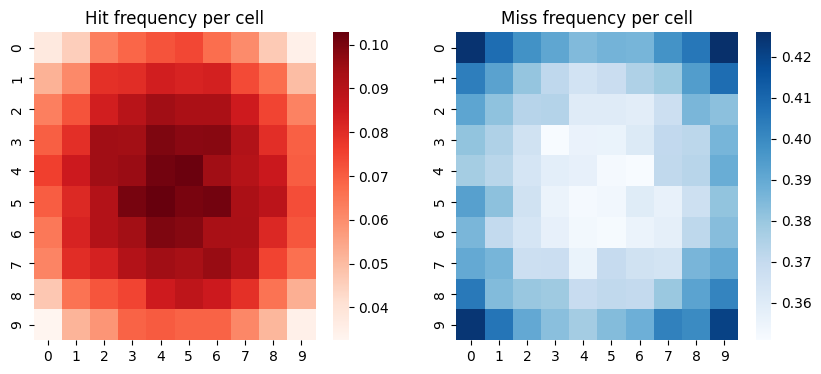

In [106]:
# Sample statistics: fraction of revealed cells per board and global hit-rate
reveal_frac = (X.sum(axis=(1,2,0))>0).mean()
print('Sample count:', X.shape[0])
# Compute hit frequency per cell across dataset (how often a cell was observed as hit)
hit_freq = (X[:, :, :, 0].sum(axis=0)) / X.shape[0]
miss_freq = (X[:, :, :, 1].sum(axis=0)) / X.shape[0]
fig, axs = plt.subplots(1,2, figsize=(10,4))
sns.heatmap(hit_freq, ax=axs[0], cmap='Reds', cbar=True)
axs[0].set_title('Hit frequency per cell')
sns.heatmap(miss_freq, ax=axs[1], cmap='Blues', cbar=True)
axs[1].set_title('Miss frequency per cell')
plt.show()

## 4. Preprocessing & feature engineering

For this baseline pipeline we flatten the grid and use the raw hit/miss channels as features for scikit-learn models. Advanced features (neighborhood counts, temporal windows) can be added later.

In [107]:
N, R, C, _ = X.shape
# Flatten grid features: two channels per cell -> 2*R*C features
X_flat = X.reshape((N, R*C*2))
# Target: flatten occupancy into binary labels per cell (we will train per-cell classifier by treating each cell as a sample)
Y_flat = Y.reshape((N, R*C))  # shape (N, R*C, 1) -> (N, R*C)
# We'll create a dataset of samples (board_index, cell_index) -> features, label
X_cells = X_flat.reshape(N, R*C, 2).reshape(N*R*C, 2)  # (N*R*C, 2)
# For each cell we use the local hit/miss channels as features. To add neighborhood features, convolve or aggregate as needed.
Y_cells = Y_flat.reshape(N*R*C)  # (N*R*C,) values in {0.0,1.0}
print('Per-cell dataset shapes:', X_cells.shape, Y_cells.shape)

Per-cell dataset shapes: (1000000, 2) (1000000,)


## 5. Train/test split and cross-validation

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_cells, Y_cells, test_size=0.2, random_state=42, stratify=Y_cells)
print('Train samples:', X_train.shape[0], 'Test samples:', X_test.shape[0])

Train samples: 800000 Test samples: 200000


## 6. Baseline & Advanced Models

We instantiate Logistic Regression, RandomForest, and a simple MLP classifier (scikit-learn).

In [109]:
# Logistic Regression baseline
logreg = LogisticRegression(max_iter=200, solver='liblinear')
logreg.fit(X_train, y_train)
y_pred_prob = logreg.predict_proba(X_test)[:,1]
print('LogReg done')
# Random Forest
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
y_rf_prob = rf.predict_proba(X_test)[:,1]
print('RandomForest done')
# MLP (sklearn)
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=200, random_state=42)
mlp.fit(X_train, y_train)
y_mlp_prob = mlp.predict_proba(X_test)[:,1]
print('MLP done')

LogReg done
RandomForest done
MLP done


## 7. Evaluation metrics and comparison

In [110]:
def eval_probs(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    ll = log_loss(y_true, y_prob)
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'auc': auc, 'log_loss': ll}

# Compute metrics for each model and present in a DataFrame
models = {'LogReg': y_pred_prob, 'RandomForest': y_rf_prob, 'MLP': y_mlp_prob}
results = {}
for name, probs in models.items():
    results[name] = eval_probs(y_test, probs)
df_results = pd.DataFrame(results).T
# Reorder columns for readability
cols = ['accuracy', 'precision', 'recall', 'f1', 'auc', 'log_loss']
df_results = df_results[cols]
# Format numeric columns
df_results = df_results.round(4)
display(df_results)

,accuracy,precision,recall,f1,auc,log_loss
LogReg,0.9074,1.0,0.4553,0.6257,0.8514,0.2485
RandomForest,0.9074,1.0,0.4553,0.6257,0.8514,0.2485
MLP,0.9074,1.0,0.4553,0.6257,0.8514,0.2487


## 8. Threshold selection & calibration (precision-recall and ROC)

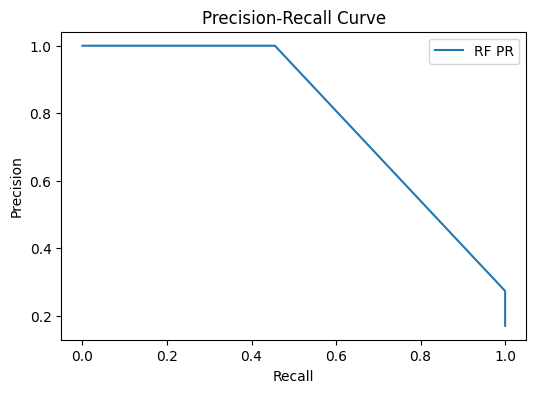

Calibrated RF AUC: 0.8514165243621545


In [111]:
from sklearn.calibration import CalibratedClassifierCV
# Example PR curve for Random Forest
precision, recall, thresholds = precision_recall_curve(y_test, y_rf_prob)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label='RF PR')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
# Optional: calibrate probabilities if desired
calibrated_rf = CalibratedClassifierCV(rf, cv=3)
calibrated_rf.fit(X_train, y_train)
y_rf_cal = calibrated_rf.predict_proba(X_test)[:,1]
print('Calibrated RF AUC:', roc_auc_score(y_test, y_rf_cal))

## 9. Visualize predictions on the grid / heatmaps

Here we map per-cell probabilities back to grid shape for a few sample boards.

C:\Users\SidRo\AppData\Local\Temp\ipykernel_9116\3100399365.py:33: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[1].scatter(miss_x, miss_y, c='yellow', marker='x', s=80, label='miss', edgecolors='black', linewidths=3, zorder=3)


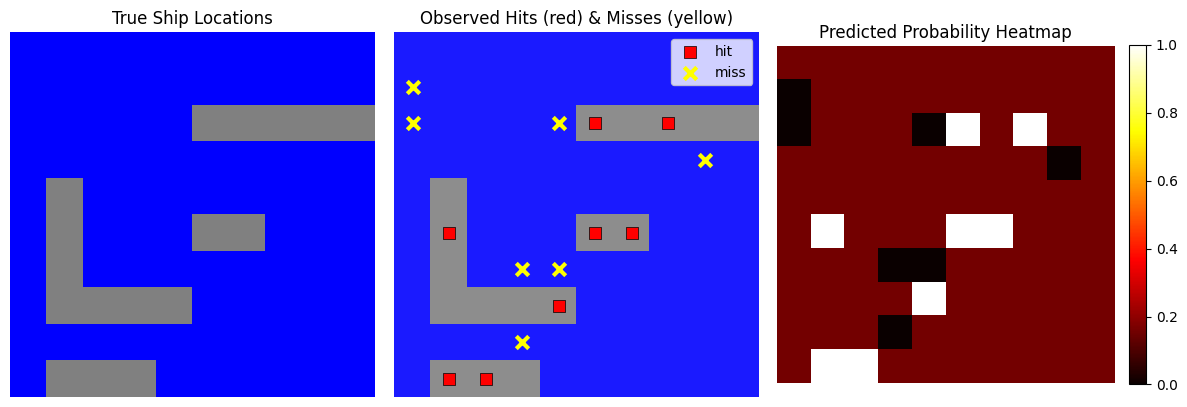

C:\Users\SidRo\AppData\Local\Temp\ipykernel_9116\3100399365.py:33: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[1].scatter(miss_x, miss_y, c='yellow', marker='x', s=80, label='miss', edgecolors='black', linewidths=3, zorder=3)


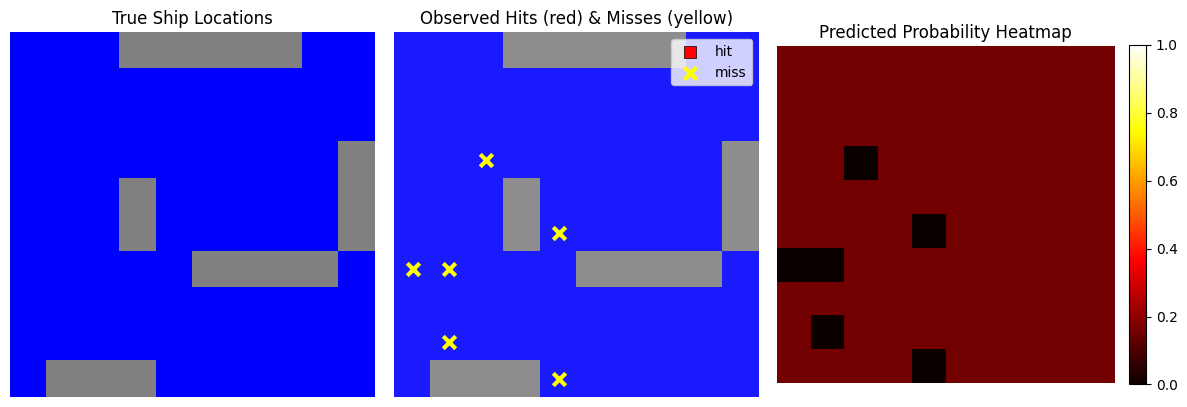

C:\Users\SidRo\AppData\Local\Temp\ipykernel_9116\3100399365.py:33: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[1].scatter(miss_x, miss_y, c='yellow', marker='x', s=80, label='miss', edgecolors='black', linewidths=3, zorder=3)


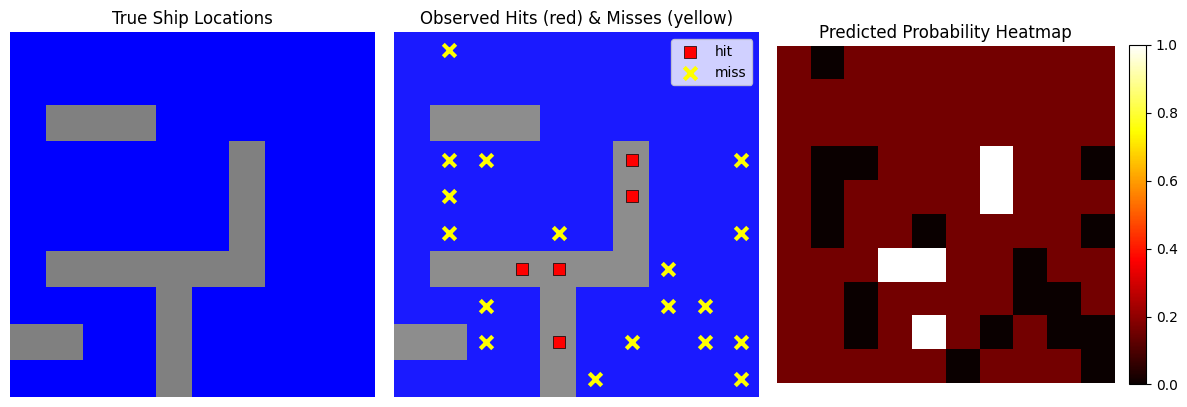

In [120]:
def visualize_board_prediction(idx=None, model=None, R=None, C=None):
    # Choose a random board if no index provided
    if idx is None:
        idx = random.randint(0, X.shape[0]-1)
    if model is None:
        model = mlp
    # True occupancy and observed hit/miss channels
    # Use defaults from constants if R/C not provided
    if R is None:
        R = DEFAULT_ROWS
    if C is None:
        C = DEFAULT_COLS
    true_grid = Y[idx].reshape((R, C))
    hit_mask = X[idx, :, :, 0]
    miss_mask = X[idx, :, :, 1]
    # Predict probabilities for each cell using the provided model
    feats = X[idx].reshape((R*C, 2))
    probs = model.predict_proba(feats)[:, 1].reshape((R, C))

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    from matplotlib.colors import ListedColormap
    board_cmap = ListedColormap(['blue', 'grey'])

    # 1) True ship locations (water blue, ships grey)
    axs[0].imshow(true_grid, cmap=board_cmap, vmin=0, vmax=1)
    axs[0].set_title('True Ship Locations')
    axs[0].set_axis_off()
    # 2) Observations: overlay hits (red) and misses (yellow) on top of board
    axs[1].imshow(true_grid, cmap=board_cmap, alpha=0.9, vmin=0, vmax=1)
    hit_y, hit_x = np.where(hit_mask == 1)
    miss_y, miss_x = np.where(miss_mask == 1)
    axs[1].scatter(hit_x, hit_y, c='red', marker='s', s=80, label='hit', edgecolors='black', linewidths=0.5, zorder=3)
    axs[1].scatter(miss_x, miss_y, c='yellow', marker='x', s=80, label='miss', edgecolors='black', linewidths=3, zorder=3)
    axs[1].set_title('Observed Hits (red) & Misses (yellow)')
    axs[1].legend(loc='upper right')
    axs[1].set_axis_off()
    # 3) Predicted probability heatmap
    im = axs[2].imshow(probs, cmap='hot', vmin=0, vmax=1)
    axs[2].set_title('Predicted Probability Heatmap')
    axs[2].set_axis_off()
    fig.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

# Show a few example boards
for _ in range(3):
    visualize_board_prediction()

## 10. Save, load, and inference helper

We save the best sklearn model with `joblib` and provide a helper `predict_grid()` which accepts recent hit/miss channels and returns a probability map.

Saved model to best_mlp.joblib


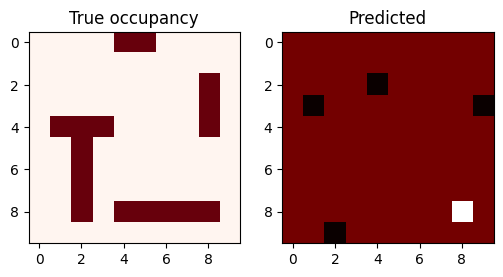

In [113]:
# Save the trained MLP as an example
model_path = 'best_mlp.joblib'
joblib.dump(mlp, model_path)
print('Saved model to', model_path)

def predict_grid(hit_mask, miss_mask, model):
    # hit_mask, miss_mask: (R, C) arrays
    R, C = hit_mask.shape
    feats = np.stack([hit_mask, miss_mask], axis=-1).reshape((R*C, 2))
    probs = model.predict_proba(feats)[:,1]
    return probs.reshape((R, C))

# Example: predict on a freshly generated board with some reveals
example_board = BattleshipBoardV1(rows=DEFAULT_ROWS, cols=DEFAULT_COLS)
arr = example_board.to_numpy_array()
revealed = np.random.rand(DEFAULT_ROWS, DEFAULT_COLS) < 0.06
hit_mask = (revealed & (arr[:,:,0]==1.0)).astype(float)
miss_mask = (revealed & (arr[:,:,0]==0.0)).astype(float)
pred_map = predict_grid(hit_mask, miss_mask, mlp)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.title('True occupancy'); plt.imshow(arr[:,:,0], cmap='Reds')
plt.subplot(1,2,2); plt.title('Predicted'); plt.imshow(pred_map, cmap='hot')
plt.show()

## 11. Unit tests for pipeline components (pytest snippets)

Below are example pytest functions you can place into `tests/test_pipeline.py` to validate loader shapes and prediction outputs.

In [114]:
# Example pytest snippets (copy into tests/test_pipeline.py)
print('Example pytest snippets:')
print('''
import numpy as np
from BattleshipBoardV1 import BattleshipBoardV1
from representation_utils import board_to_tensor

def test_generate_single_board_tensor():
    b = BattleshipBoardV1(rows=8, cols=8, ship_sizes=[])
    arr = b.to_numpy_array()
    assert arr.shape == (8,8,3)

def test_predict_grid_output_shape():
    # small model or dummy classifier that returns 0.5 for all
    R, C = 8, 8
    hit_mask = np.zeros((R,C))
    miss_mask = np.zeros((R,C))
    # simulate a simple model with predict_proba
    class Dummy:
        def predict_proba(self, X):
            return np.tile([[0.5,0.5]], (X.shape[0],1))
    p = Dummy()
    from your_notebook_module import predict_grid
    out = predict_grid(hit_mask, miss_mask, p)
    assert out.shape == (R,C)
''')

Example pytest snippets:

import numpy as np
from BattleshipBoardV1 import BattleshipBoardV1
from representation_utils import board_to_tensor

def test_generate_single_board_tensor():
    b = BattleshipBoardV1(rows=8, cols=8, ship_sizes=[])
    arr = b.to_numpy_array()
    assert arr.shape == (8,8,3)

def test_predict_grid_output_shape():
    # small model or dummy classifier that returns 0.5 for all
    R, C = 8, 8
    hit_mask = np.zeros((R,C))
    miss_mask = np.zeros((R,C))
    # simulate a simple model with predict_proba
    class Dummy:
        def predict_proba(self, X):
            return np.tile([[0.5,0.5]], (X.shape[0],1))
    p = Dummy()
    from your_notebook_module import predict_grid
    out = predict_grid(hit_mask, miss_mask, p)
    assert out.shape == (R,C)



## 12. Notes & next steps

- This notebook provides a baseline approach by treating each grid cell independently using the local hit/miss observations. For better performance, train a convolutional model that uses the full 2D context (see optional PyTorch section below).
- You can extend the dataset by simulating time-ordered sequences (reveals over time) and using recurrent or temporal convolutional models.
- Consider adding neighborhood features and multi-scale aggregations for better spatial context.